This notebook compares 3 methods for determining confidence intervals of least square regressions for fitting TL curves:


1.   built-in seaborn implementation
2.   the 'delta method'
3.   The built in kapteyn, kmpfit implementation

https://seaborn.pydata.org/tutorial/regression.html
https://www.astro.rug.nl/software/kapteyn/kmpfit.html#module-kapteyn.kmpfit
https://github.com/gjpelletier/delta_method?tab=readme-ov-file

Methods 2 and 3 agree for both the log-linear geometric spreading fit and the damped geometric spreading which includes the extra term.  However, the seaborn implementation does not exactly agree with the other two methods for either version of the log-linear fits. This may be because the seaborn implementation uses the exact solution for confidence intervals while the other two are numerical approximations.

In [4]:
# @title Delta method
def delta_method(pcov,popt,x_new,f,x,y,alpha):

    """
    Function to calculate the confidence interval and prediction interval for any user-defined regression function using the delta-method as described in Sec 5.1 of the following online statistics lecture:
    https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html
    by Greg Pelletier (gjpelletier@gmail.com)
    SYNTAX
    result = delta_method(pcov,popt,x_new,f,x,y,alpha)
    INPUT
    - pcov = variance-covariance matrix of the model parameters (e.g. from scipy or lmfit)
    - popt = optimum best-fit parameters of the regression function (e.g. from scipy or lmfit)
    - x_new = new x values to evaluate new predicted y_new values (e.g. x_new=linspace(min(x),max(x),100)
    - f = model function for scipy.opt_curve_fit with x as first argument and parameters as separate arguments. For example, if using the 4-parameter sigmoid function, then
      def f(x, A, gamma, tau, S):
          return (A-S) / ( 1 + exp(-gamma * (x - tau)) ) + S
    - x = observed x
    - y = observed y
    - alpha = significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    OUTPUT
    - result = dictionary of output varlables with the following keys:
    - 'popt': optimum best-fit parameter values used as input
    - 'pcov': variance-covariance matrix used as input
    - 'alpha': input significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    - 'x': observed x values used as input
    - 'y': observed y values used as input
    - 'yhat': predicted y at observed x values
    - 'x_new': new x-values used as input to evaluate unew predicted y_new values
    - 'y_new': new predicted y_new values at new x_new values
    - 'lwr_conf': lower confidence interval for each value in x_new
    - 'upr_conf': upper confidence interval for each value in x_new
    - 'lwr_pred': lower prediction interval for each value in x_new
    - 'upr_pred': upper prediction interval for each value in x_new
    - 'grad_new': derivative gradients at x_new (change in f(x_new) per change in each popt)
    - 'G_new': variance due to each parameter at x_new
    - 'GS_new': variance due to all parameters combined at x_new
    - 'SST': Sum of Squares Total
    - 'SSR': Sum of Squares Regression
    - 'SSE': Sum of Squares Error
    - 'MSR': Mean Square Regression
    - 'MSE': Mean Square Error of the residuals
    - 'syx': standard error of the estimate
    - 'nobs': number of observations
    - 'nparam': number of parameters
    - 'df': degrees of freedom = nobs-nparam
    - 'qt': 2-tailed t-statistic at alpha
    - 'Fstat': F-statistic = MSR/MSE
    - 'dfn': degrees of freedom for the numerator of the F-test = nparam-1
    - 'dfd': degrees of freedom for the denominator of the F-test = nobs-nparam
    - 'pvalue': signficance level of the regression from the probability of the F-test
    - 'rsquared': r-squared = SSR/SST
    - 'adj_rsquared': adjusted squared
    """

    import numpy as np
    from scipy import stats
    import sys

    ctrl = np.isreal(x).all() and (not np.isnan(x).any()) and (not np.isinf(x).any()) and x.ndim==1
    if not ctrl:
      print('Check x: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    ctrl = np.isreal(y).all() and (not np.isnan(y).any()) and (not np.isinf(y).any()) and y.ndim==1
    if not ctrl:
      print('Check y: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    ctrl = np.isreal(x_new).all() and (not np.isnan(x_new).any()) and (not np.isinf(x_new).any()) and x_new.ndim==1
    if not ctrl:
      print('Check x_new: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    ctrl = np.isreal(popt).all() and (not np.isnan(popt).any()) and (not np.isinf(popt).any()) and popt.ndim==1
    if not ctrl:
      print('Check popt: it needs be a vector of real numbers with no infinite or nan values!','\n')
      sys.exit()
    ctrl =  np.size(x)==np.size(y)
    if not ctrl:
      print('Check x and y: x and y need to be the same size!','\n')
      sys.exit()
    ctrl = np.shape(pcov)[0]==np.shape(pcov)[1] and np.shape(pcov)[0]==np.size(popt)
    if not ctrl:
      print('Check pcov and popt: pcov must be a square covariance matrix for popt with dimensions length(popt) x length(popt)!!','\n')
      sys.exit()

    # - - -
    # calculate predicted y_new at each x_new
    y_new = f(x_new,*popt)
    # calculate derivative gradients at x_new (change in f(x_new) per change in each popt)
    grad_new = np.empty(shape=(np.size(x_new),np.size(popt)))
    h = 1e-8       # h= small change for each popt to balance truncation error and rounding error of the gradient
    for i in range(np.size(popt)):
        # make a copy of popt
        popt2 = np.copy(popt)
        # gradient forward
        popt2[i] = (1+h) * popt[i]
        y_new2 = f(x_new,*popt2)
        dy = y_new2 - y_new
        dpopt = popt2[i] - popt[i]
        grad_up = dy / dpopt
        # gradient backward
        popt2[i] = (1-h) * popt[i]
        y_new2 = f(x_new,*popt2)
        dy = y_new2 - y_new
        dpopt = popt2[i] - popt[i]
        grad_dn = dy / dpopt
        # centered gradient is the average gradient forward and backward
        grad_new[:,i] = (grad_up + grad_dn) / 2
    # calculate variance in y_new due to each parameter and for all parameters combined
    G_new = np.matmul(grad_new,pcov) * grad_new         # variance in y_new due to each popt at each x_new
    GS_new = np.sum(G_new,axis=1)                       # total variance from all popt values at each x_new
    # - - -
    # # lwr_conf and upr_conf are confidence intervals of the best-fit curve
    nobs = np.size(x)
    nparam = np.size(popt)
    df = nobs - nparam
    qt = stats.t.ppf(1-alpha/2, df)
    delta_f = np.sqrt(GS_new) * qt
    lwr_conf = y_new - delta_f
    upr_conf = y_new + delta_f
    # - - -
    # # lwr_pred and upr_pred are prediction intervals of new observations
    yhat = f(x,*popt)
    SSE = np.sum((y-yhat) ** 2)                 # sum of squares (residual error)
    MSE = SSE / df                              # mean square (residual error)
    syx = np.sqrt(MSE)                          # std error of the estimate
    delta_y = np.sqrt(GS_new + MSE) * qt
    lwr_pred = y_new - delta_y
    upr_pred = y_new + delta_y
    # - - -
    # optional additional outputs of regression statistics
    SST = np.sum(y **2) - np.sum(y) **2 / nobs  # sum of squares (total)
    SSR = SST - SSE                             # sum of squares (regression model)
    MSR = SSR / (np.size(popt)-1)              # mean square (regression model)
    Fstat = MSR / MSE           # F statistic
    dfn = np.size(popt) - 1    # df numerator = degrees of freedom for model = number of model parameters - 1
    dfd = df                    # df denomenator = degrees of freedom of the residual = df = nobs - nparam
    pvalue = 1-stats.f.cdf(Fstat, dfn, dfd)      # p-value of F test statistic
    rsquared = SSR / SST                                                        # ordinary rsquared
    adj_rsquared = 1-(1-rsquared)*(np.size(x)-1)/(np.size(x)-np.size(popt)-1)  # adjusted rsquared
    # - - -
    # make the dictionary of output variables from the delta-method
    result = {
            'popt': popt,
            'pcov': pcov,
            'alpha': alpha,
            'x': x,
            'y': y,
            'yhat': yhat,
            'x_new': x_new,
            'y_new': y_new,
            'lwr_conf': lwr_conf,
            'upr_conf': upr_conf,
            'lwr_pred': lwr_pred,
            'upr_pred': upr_pred,
            'grad_new': grad_new,
            'G_new': G_new,
            'GS_new': GS_new,
            'SST': SST,
            'SSR': SSR,
            'SSE': SSE,
            'MSR': MSR,
            'MSE': MSE,
            'syx': syx,
            'nobs': nobs,
            'nparam': nparam,
            'df': df,
            'qt': qt,
            'Fstat': Fstat,
            'dfn': dfn,
            'dfd': dfd,
            'pvalue': pvalue,
            'rsquared': rsquared,
            'adj_rsquared': adj_rsquared
            }

    return result

In [3]:
# @title install Kapteyn
!pip install https://www.astro.rug.nl/software/kapteyn/kapteyn-3.4.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kapteyn: filename=kapteyn-3.4-cp310-cp310-linux_x86_64.whl size=2439039 sha256=d9b03d80813e69af15c9747745208064b420c01f26453bd804eb9fd029f40728
  Stored in directory: /root/.cache/pip/wheels/14/10/a5/92fe6dad813c5858ee4c9a3d2961e441f1d985c113bd9f4cae
Successfully built kapteyn


Log-Linear regression comparsion, with explicit log methods for 2 and 3

In [6]:
import numpy as np
L = np.array([176.0,175,168.6,169,161.0,162.0,147.2,145.0])
r = np.array([700,700,1520,1520,2980,2980,10000,10000])

[ 3.55011381 12.07676641]


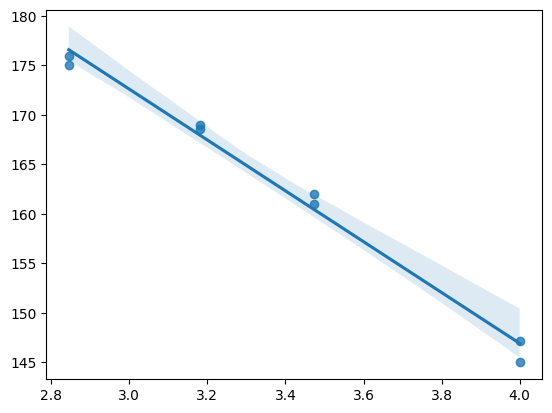

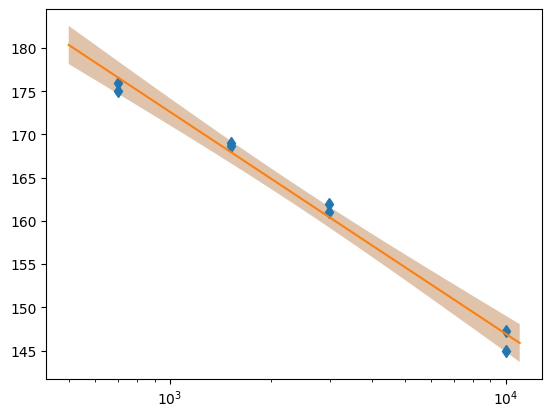

In [7]:
# @title Log-linear regression comparisons, with non-linear (retain log10) for (2) and (3)
from kapteyn import kmpfit
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

def geometricSpreading(r,F,SL):
  return SL-F*np.log10(r)

def geometricSpreading2(p,r):
  return p[0]-p[1]*np.log10(r)


# seaborn version
logr = np.log10(r)
sb.regplot(x=logr,y=L)

y_data = L
x_data = r
# scipy/uncertainties implementation from github
# https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit
# averages and dispersion of data
a = 0.02 #(1-0.95, 95% CI)
tval = stats.t.ppf(1.0-a/2, len(L)-2)

best_fit_ab, covar = curve_fit(geometricSpreading, x_data, y_data)

sigma_ab = tval*np.sqrt(np.diagonal(covar))
print(sigma_ab)
x_fit = np.linspace(500,11000)
y_fit = geometricSpreading(x_fit,*best_fit_ab)

fig,ax = plt.subplots()

ax.semilogx(r,L,linestyle='none',marker='d')
ax.semilogx(x_fit,y_fit)

## delta method
out = delta_method(covar,best_fit_ab,x_fit,geometricSpreading,x_data,y_data,alpha=0.05)
ax.fill_between(x_fit,out['lwr_conf'],out['upr_conf'],alpha=0.2)
#ax.semilogx(x_fit,out['lwr_conf'])

# Using kapteyn
dfdp = [np.ones_like(x_fit), -np.log10(x_fit)]

f = kmpfit.simplefit(geometricSpreading2,[200,15],r,L)
_, ci_upper, ci_lower = f.confidence_band(x_fit, dfdp, 0.95, geometricSpreading2)
ax.fill_between(x_fit,ci_lower,ci_upper,alpha=0.3)

linear for all 3

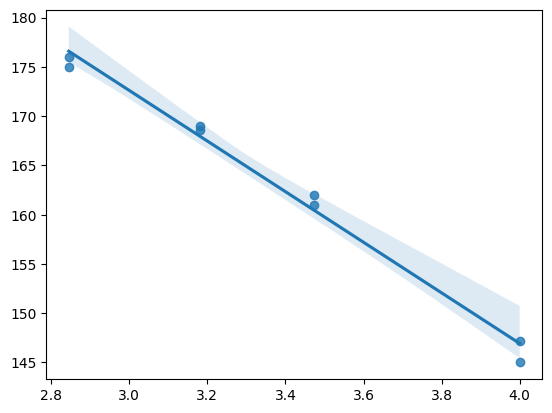

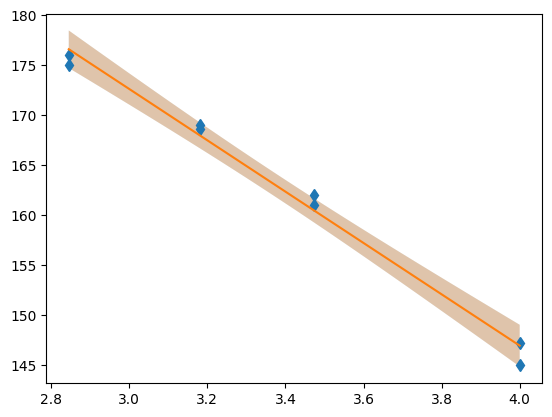

In [8]:
# @title Log-linear comparison
from kapteyn import kmpfit
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

def geometricSpreading(logr,F,SL):
  return SL-F*logr

def geometricSpreading2(p,logr):
  return p[0]-p[1]*logr



# seaborn version
logr = np.log10(r)
sb.regplot(x=logr,y=L)

y_data = L
x_data = logr


best_fit_ab, covar = curve_fit(geometricSpreading, x_data, y_data)


x_fit = np.linspace(np.min(logr),np.max(logr))
y_fit = geometricSpreading(x_fit,*best_fit_ab)

fig,ax = plt.subplots()

ax.plot(logr,L,linestyle='none',marker='d')
ax.plot(x_fit,y_fit)

## delta method
out = delta_method(covar,best_fit_ab,x_fit,geometricSpreading,x_data,y_data,alpha=0.05)
ax.fill_between(x_fit,out['lwr_conf'],out['upr_conf'],alpha=0.2)
#ax.semilogx(x_fit,out['lwr_conf'])

# Using kapteyn
dfdp = [np.ones_like(x_fit), -x_fit]

f = kmpfit.simplefit(geometricSpreading2,[200,15],logr,L)
_, ci_upper, ci_lower = f.confidence_band(x_fit, dfdp, 0.95, geometricSpreading2)
ax.fill_between(x_fit,ci_lower,ci_upper,alpha=0.3)

Damped Geometric spreading comparison of methods 2 and 3


[6.94438878e+00 2.06106178e+01 8.01662538e-04]


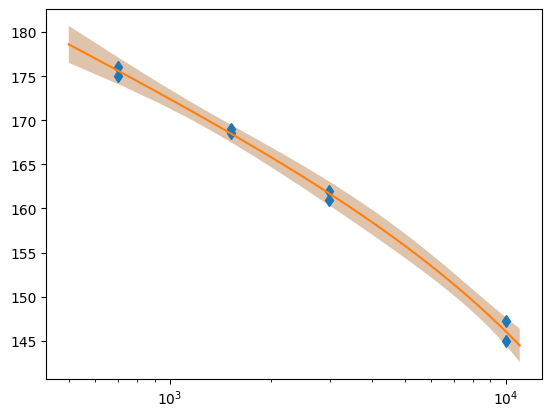

In [9]:
# @title Damped Geometric spreading comparison
def geometricSpreading(r,F,SL):
  return SL-F*np.log10(r)



def dampedGeoSpreading(r,F,SL,alpha):
  return SL-F*np.log10(r)-alpha*r

def dampedGeoSpreading2(p,r):
  return p[0]-p[1]*np.log10(r)-p[2]*r



y_data = L
x_data = r
# scipy/uncertainties implementation from github
# https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit
# averages and dispersion of data
a = 0.02 #(1-0.95, 95% CI)
tval = stats.t.ppf(1.0-a/2, len(L)-2)

best_fit_ab, covar = curve_fit(dampedGeoSpreading, x_data, y_data, bounds = (0,[100,500,100])
                               )
sigma_ab = tval*np.sqrt(np.diagonal(covar))
print(sigma_ab)
x_fit = np.linspace(500,11000)
y_fit = dampedGeoSpreading(x_fit,*best_fit_ab)
#y_upper = geometricSpreading(x_fit,*(best_fit_ab+sigma_ab))
#y_lower = geometricSpreading(x_fit,*(best_fit_ab-sigma_ab))
# scipy only method#
fig,ax = plt.subplots()

ax.semilogx(r,L,linestyle='none',marker='d')
ax.semilogx(x_fit,y_fit)

## delta method
out = delta_method(covar,best_fit_ab,x_fit,dampedGeoSpreading,x_data,y_data,alpha=0.05)
ax.fill_between(x_fit,out['lwr_conf'],out['upr_conf'],alpha=0.2)
#ax.semilogx(x_fit,out['lwr_conf'])

# Using kapteyn
dfdp = [np.ones_like(x_fit), -np.log10(x_fit), -x_fit]

f = kmpfit.simplefit(dampedGeoSpreading2,[200,15,.01],r,L)
_, ci_upper, ci_lower = f.confidence_band(x_fit, dfdp, 0.95, dampedGeoSpreading2)
ax.fill_between(x_fit,ci_lower,ci_upper,alpha=0.3)